In [1]:
import numpy as np
import random
import pandas as pd
import re
import copy
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# getting data in dictionary format

In [2]:
def get_data(filename):
    data = np.genfromtxt(filename, delimiter=" ", skip_header = 3, dtype = 'int')
    data_update = np.delete(data, 2, 1)
    dict1={}
    for i in range(data_update.shape[0]):
        try:
            dict1[data_update[i][0]].add(data_update[i][1])
        except KeyError:
            dict1[data_update[i][0]]={data_update[i][1]}
    return (dict1)

#### Jaccard distance function

In [3]:
## define a function to calculate the jacard distance between 2 vector
def jaccardDistance(a,b):
   
    try:
        return 1 - float(len(a.intersection(b))) / float(len(a.union(b)))
    except TypeError:
        print('Invalid type. Type set expected.')

#### Distance Matrix
Created a matrix for distance between all the 2 vector

In [4]:
def initializeMatrix(dic):
    jaccardMatrix=np.ones([len(dic.keys())+1,len(dic.keys())+1])
        
    for ID1 in dic.keys():
        for ID2 in dic.keys():
            if ID2>=ID1:
                distance=jaccardDistance(dic[ID1], dic[ID2])
                jaccardMatrix[ID1][ID2]=distance
                jaccardMatrix[ID2][ID1]=distance
    return jaccardMatrix

### Iniatialize seeds using K means++ startegy

In [5]:
## function for using K means ++ startegy for calculating initial 4 centeriod of the cluster
def initializeSeeds(dict1,k):
    

    
    seed = random.choice(list(dict1.keys()))        

    # 2. For each data point x, compute D(x),
    # the distance between x and the nearest center that has already been chosen
    seeds = set([seed])
    while len(seeds) < k:
        distanceMatrix = {}
        sum_sqr_dist = 0
        for seed in seeds:
          
            for ID in dict1.keys():
                if ID == seed:
                    continue     
                dist = jaccardMatrix[seed][ID]
                if ID not in distanceMatrix or dist < distanceMatrix[ID]:
                    distanceMatrix[ID] = dist
        prob_dict = {}
        for ID in distanceMatrix:
            sum_sqr_dist += distanceMatrix[ID] * distanceMatrix[ID]
        for ID in distanceMatrix:
            prob_dict[ID] = distanceMatrix[ID] * distanceMatrix[ID] / sum_sqr_dist

        # 3. Choose one new data point at random as a new center,
        # using a weighted probability distribution
        # where a point x is chosen with probability proportional to D(x)^2.
        IDs, weights = list(prob_dict.keys()), list(prob_dict.values())
        seed = random.choices(IDs, weights)[0]
        seeds.add(seed)

    # 4. Repeat Steps 2 and 3 until k centers have been chosen.
    return list(seeds)

#### Iniatializing clusters function

In [6]:
 def initializeClusters(dic,k,seeds):
        
        
        for ID in dic.keys():
            rev_clusters[ID] = -1

        
        for k in range(k):
            clusters[k] = set([seeds[k]])
            rev_clusters[seeds[k]] = k

#### Calculating new clusters function

In [7]:
def calcNewClusters(dic,clusters,rev_clusters,k):
        # Initialize new cluster
        new_clusters = {}
        new_rev_cluster = {}
        for k in range(k):
            new_clusters[k] = set()

        for ID1 in dic.keys():
            min_dist = float("inf")
            min_cluster = rev_clusters[ID1]

            # Calculate min average distance to each cluster
            for k in clusters:
                dist = 0
                count = 0
                for ID2 in clusters[k]:
                    dist += jaccardMatrix[ID1][ID2]
                    count += 1
                if count > 0:
                    avg_dist = dist/float(count)
                    if min_dist > avg_dist:
                        min_dist = avg_dist
                        min_cluster = k
            new_clusters[min_cluster].add(ID1)
            new_rev_cluster[ID1] = min_cluster
        return new_clusters, new_rev_cluster

In [8]:
def converge(dic,clusters,rev_clusters,k):
        # Initialize previous cluster to compare changes with new clustering
        new_clusters, new_rev_clusters = calcNewClusters(dic,clusters,rev_clusters,k)
        clusters = copy.deepcopy(new_clusters)
        rev_clusters = copy.deepcopy(new_rev_clusters)

        # Converges until old and new iterations are the same
        iterations = 1
        while iterations < max_iterations:
            new_clusters, new_rev_clusters = calcNewClusters(dic,clusters,rev_clusters,k)
            iterations += 1
            if rev_clusters != new_rev_clusters:
                clusters = copy.deepcopy(new_clusters)
                rev_clusters = copy.deepcopy(new_rev_clusters)
            else:
                print(iterations)
                return clusters,rev_clusters

In [9]:
def get_centroids(clusters,jm):
    centroids={}
    
    for k in clusters.keys():
        clust=list(clusters[k])
        col_sum=list(jm.loc[clust,clust].sum(axis=0))
        ind=clust[col_sum.index(min(col_sum))]
        centroids[k]=ind
        
    return centroids
        

In [10]:
def tot_dist(clusters,jm,centroids):
    sum_k=0
    for k in clusters.keys():
        clust1=list(clusters[k])
        sum_k=sum_k + jm.loc[clust1,[centroids[k]]].sum(axis=0)[centroids[k]]
    return sum_k

### Run for KOS

In [23]:
filename = "E:/docword.kos.txt"
dict1=get_data(filename)

In [25]:
jaccardMatrix=initializeMatrix(dict1)

In [74]:
jm=pd.DataFrame(jaccardMatrix)

In [75]:
max_iterations=100

In [76]:
s={}
for k in tqdm(range(2,16)):
    seeds=initializeSeeds(dict1,k)
    rev_clusters={}
    clusters={}
    initializeClusters(dict1,k,seeds)
    clust,revclust=converge(dict1,clusters,rev_clusters,k)
    centroids=get_centroids(clust,jm)
    s[k]=tot_dist(clust,jm,centroids)


C:\Users\india\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/14 [00:00<?, ?it/s]

19
10
36
39
23
19
15
15
25
15
20
13
12
16


In [89]:
s1={}
for k in tqdm(range(16,19)):
    seeds=initializeSeeds(dict1,k)
    rev_clusters={}
    clusters={}
    initializeClusters(dict1,k,seeds)
    clust,revclust=converge(dict1,clusters,rev_clusters,k)
    centroids=get_centroids(clust,jm)
    s[k]=tot_dist(clust,jm,centroids)


C:\Users\india\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/3 [00:00<?, ?it/s]

15
30
10


In [103]:
len(x_)

14

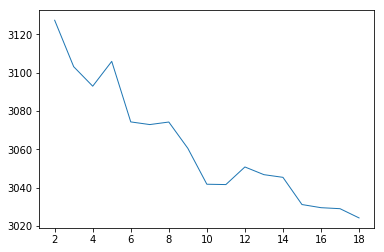

In [104]:
x_=np.linspace(2,18,17)
sns.lineplot(x=x_, y=list(s.values()), sort=False, lw=1)


### Run for nips


In [13]:
filename = "E:/docword.nips.txt"
dict2=get_data(filename)

In [14]:
jaccardMatrix=initializeMatrix(dict2)
jm=pd.DataFrame(jaccardMatrix)
max_iterations=100


In [15]:
s3={}
for k in tqdm(range(2,16)):
    seeds=initializeSeeds(dict2,k)
    rev_clusters={}
    clusters={}
    initializeClusters(dict2,k,seeds)
    clust,revclust=converge(dict2,clusters,rev_clusters,k)
    centroids=get_centroids(clust,jm)
    s3[k]=tot_dist(clust,jm,centroids)


C:\Users\india\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/14 [00:00<?, ?it/s]

3
13
10
8
12
13
15
31
17
14
12
16
10
13


In [17]:
len(s3)

14

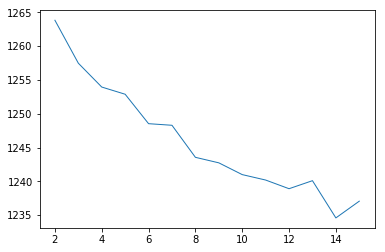

In [19]:
x_=np.linspace(2,15,14)
sns.lineplot(x=x_, y=list(s3.values()), sort=False, lw=1)

# Run for enron Dataset

## dataset is very large

In [11]:
from collections import Counter
import collections

In [12]:
filename = "E:/docword_enron.txt"



In [14]:
## calculaing most frequent word from enron
data = np.genfromtxt(filename, delimiter=" ", skip_header = 3, dtype = 'int')
l=[data[i][1] for i in range(len(data))]
u=Counter(l)
sorted_x = sorted(u.items(), key=lambda kv: kv[1], reverse=True)
l2=[sorted_x[i][0] for i in range(20000)]


In [19]:
l2

[15617,
 1583,
 15231,
 25181,
 17292,
 10933,
 11468,
 6106,
 3284,
 10636,
 8243,
 18848,
 14735,
 21289,
 9867,
 19190,
 3450,
 21011,
 4865,
 17486,
 19484,
 5921,
 16267,
 22459,
 14559,
 10543,
 19793,
 24860,
 5511,
 17761,
 9460,
 13091,
 10027,
 20480,
 5299,
 20481,
 18978,
 4802,
 24463,
 19592,
 9970,
 15738,
 8201,
 22535,
 17481,
 6182,
 11897,
 16213,
 27710,
 22547,
 25180,
 12382,
 4025,
 19580,
 7526,
 13087,
 5897,
 22541,
 10312,
 289,
 18677,
 23837,
 5463,
 17208,
 18830,
 18224,
 24445,
 11885,
 21043,
 46,
 11823,
 6993,
 12379,
 285,
 118,
 19959,
 2426,
 25221,
 6650,
 25282,
 6099,
 15656,
 2053,
 19117,
 20734,
 13271,
 11585,
 15616,
 21200,
 9404,
 1445,
 23419,
 9236,
 10190,
 27294,
 5066,
 25901,
 536,
 19497,
 12179,
 2233,
 25029,
 16314,
 5291,
 19618,
 147,
 5425,
 9434,
 9454,
 3722,
 19655,
 6251,
 7888,
 24727,
 15084,
 17245,
 232,
 4863,
 10474,
 4115,
 20282,
 4468,
 12803,
 18342,
 5693,
 9732,
 18276,
 2068,
 6880,
 9289,
 17451,
 14738,
 19

In [24]:
l3=l2

In [21]:
l=[]
for i in range(len(data)):
    if data[i][1] not in  l2:
        u=(data[i][0], data[i][1], data[i][2])
        l.append(u)
        
    

In [27]:
dict5={}
for i in range(len(l)):
    try:
        dict5[l[i][0]].add(l[i][1])
    except KeyError:
        dict5[l[i][0]]={l[i][1]}
    

In [ ]:
dict5

In [28]:
dict6={}
k=1
for key in dict5:
    dict6[k]=dict5[key]
    k=k+1
    

In [29]:
jaccardMatrix=initializeMatrix(dict6)
jm=pd.DataFrame(jaccardMatrix)
max_iterations=100


In [ ]:
dict6

In [30]:
s4={}
for k in tqdm(range(2,16)):
    seeds=initializeSeeds(dict6,k)
    rev_clusters={}
    clusters={}
    initializeClusters(dict6,k,seeds)
    clust,revclust=converge(dict6,clusters,rev_clusters,k)
    centroids=get_centroids(clust,jm)
    s4[k]=tot_dist(clust,jm,centroids)


C:\Users\india\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/14 [00:00<?, ?it/s]

14
15
16
13
12


KeyboardInterrupt: 

In [31]:
s4

{2: 18352.305843851696,
 3: 18341.241027007818,
 4: 18332.50324617911,
 5: 18322.949204050194,
 6: 18309.88967197308}

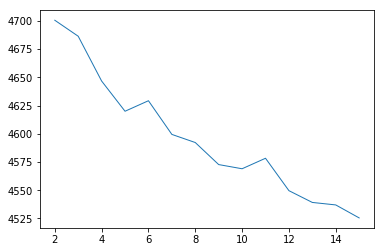

In [50]:
x_=np.linspace(2,15,14)
sns.lineplot(x=x_, y=list(s4.values()), sort=False, lw=1)

In [54]:
%who


calcNewClusters	 centroids	 clust	 clusters	 converge	 copy	 d	 dict1	 dict3	 
filename	 get_centroids	 get_data	 i	 initializeClusters	 initializeMatrix	 initializeSeeds	 jaccardDistance	 jaccardMatrix	 
jm	 k	 key	 max_iterations	 np	 pd	 plt	 random	 re	 
rev_clusters	 revclust	 s3	 s4	 seeds	 sns	 tot_dist	 tqdm	 up_dict	 
x_	 
